In [1]:
import scipy.io
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import ddm
from itertools import product

## Load Data

In [2]:
columns =['Subject', 'Noise Color', 'Trial', 'Noise Trial', 'Session', 'Coherence', 'Correct Response', 'Reaction Time']
data = pd.read_csv('allData.txt', header = None, names=columns)
data['Subject'] = [sub.split('_')[2][-6:] for sub in data['Subject']]

Text(0.5, 1.0, 'Reaction Times vs. Noise Level')

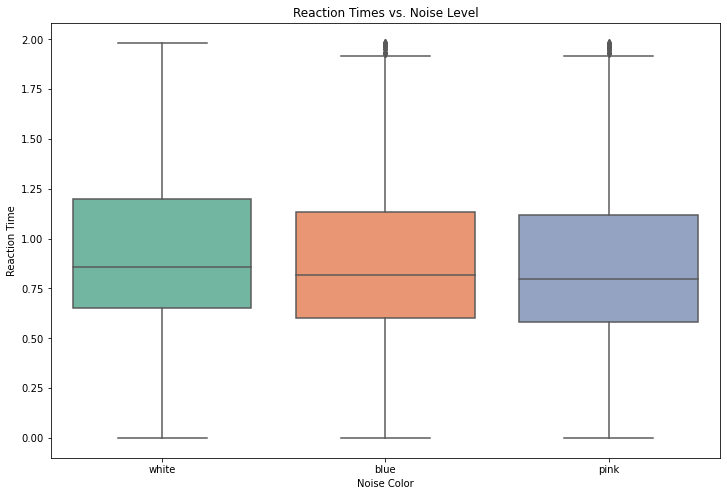

In [10]:
fig, ax = plt.subplots(figsize=(12,8))
idx = ((data['Noise Color'] == 'white') | (data['Noise Color'] == 'blue') | (data['Noise Color'] == 'pink')) & (data['Correct Response'] == 1)
sns.boxplot(data=data[idx], x='Noise Color', y='Reaction Time', palette='Set2',ax=ax)
ax.set_title('Reaction Times vs. Noise Level')

## Plot Reaction Times, Coherence Resets and Window before Reset
### White Noise

Mean Coherence Threshold:  44.285714285714285


Text(0.5, 1.0, 'Single Subject Reaction Times and Coherence Resets')

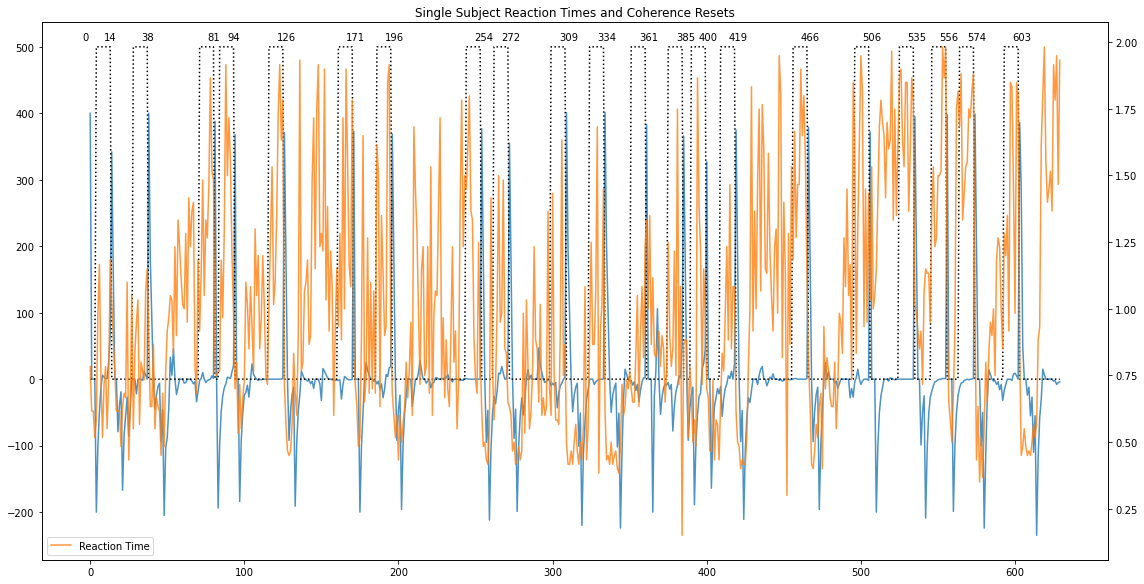

In [4]:
white = data[(data['Noise Color'] == 'white') & (data['Subject']=='LAB001') & (data['Correct Response']==1)]
rt = white['Reaction Time'].to_numpy()
trials = np.arange(len(rt))

diff_coh = np.diff(white['Coherence'], prepend=0)
reset = diff_coh>=200
reset_trials = trials[reset]
min_reset_inter = 10
false_reset = [n+1 for n, reset_diff in enumerate(np.diff(reset_trials)) if reset_diff <= min_reset_inter]
reset_trials = np.delete(reset_trials, false_reset)

window_size = 10
analyze_trials = [np.arange(trial-window_size, trial) for trial in reset_trials[1:]]
analyze_trials = [val for window in analyze_trials for val in window]
analyze_windows = np.zeros(len(trials))
analyze_windows[analyze_trials] = 1.

thresh_coherence = white.iloc[analyze_trials,5]
print('Mean Coherence Threshold: ', np.mean(thresh_coherence))


fig, ax = plt.subplots(figsize=(16,8))
ax.plot(diff_coh, alpha=0.8)
ax.plot(analyze_windows*500, ':k')
for trial in reset_trials:
    ax.text(s=str(trial), x=trial-5, y=510)
# Plot Reaction Times
ax2 = ax.twinx() 
ax2.plot(trials, rt, color='tab:orange', alpha=0.8, label = 'Reaction Time')
ax2.legend(loc='lower left')
fig.tight_layout()
ax.set_title('Single Subject Reaction Times and Coherence Resets')

In [5]:
colors = ['white', 'blue', 'pink']
subs = np.unique(data['Subject'])
res = {'Subject':[], 'Noise Color': [], 'Coherence Thresh': []}

for noise_color, sub in product(colors,subs):
    df = data[(data['Noise Color'] == noise_color) & (data['Subject']==sub) & (data['Correct Response']==1)]
    if len(df)==0:
        continue
    rt = df['Reaction Time'].to_numpy()
    trials = np.arange(len(rt))

    diff_coh = np.diff(df['Coherence'], prepend=0)
    reset = diff_coh>=200
    reset_trials = trials[reset]
    min_reset_inter = 10
    false_reset = [n+1 for n, reset_diff in enumerate(np.diff(reset_trials)) if reset_diff <= min_reset_inter]
    reset_trials = np.delete(reset_trials, false_reset)

    window_size = 10
    analyze_trials = [np.arange(trial-window_size, trial) for trial in reset_trials[1:]]
    analyze_trials = [val for window in analyze_trials for val in window]
    analyze_windows = np.zeros(len(trials))
    analyze_windows[analyze_trials] = 1.

    thresh_coherence = df.iloc[analyze_trials,5]
    res['Subject'].append(sub); res['Noise Color'].append(noise_color)
    res['Coherence Thresh'].append(np.mean(thresh_coherence))

res_df = pd.DataFrame(res)

Text(0.5, 1.0, 'Coherence Thresholds')

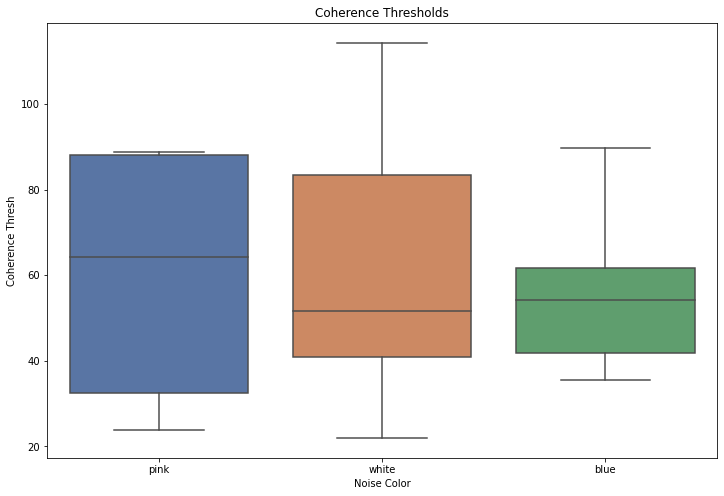

In [6]:
fig, ax = plt.subplots(figsize=(12,8))
sns.boxplot(data=res_df, x='Noise Color', y='Coherence Thresh', 
            order=['pink', 'white', 'blue'], ax=ax, palette='deep')
ax.set_title('Coherence Thresholds')

## Plot Reaction Time vs. Coherence 
## White Noise

Text(0.5, 1.0, 'Reaction Time vs. Motion Coherence')

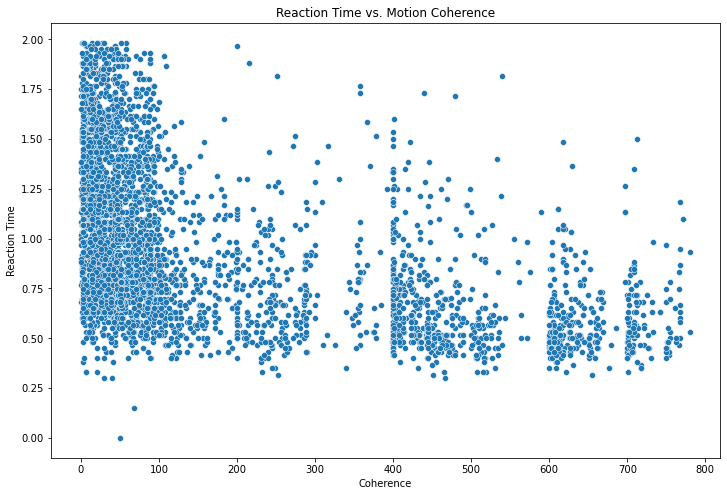

In [7]:
df = data[(data['Noise Color'] == 'white') & (data['Correct Response']==1)]
fig, ax = plt.subplots(figsize=(12,8))
sns.scatterplot(data=df, x='Coherence', y='Reaction Time', ax=ax)
ax.set_title('Reaction Time vs. Motion Coherence')

## Bined Coherence Values

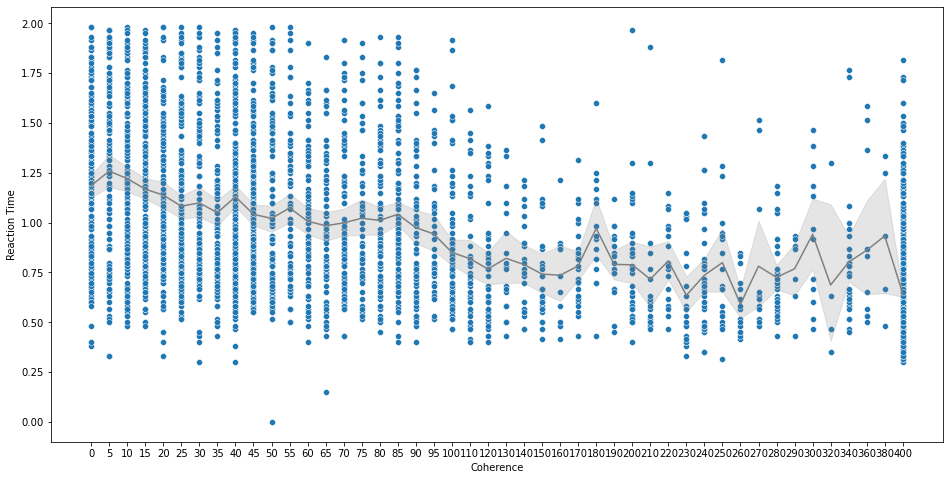

In [8]:
binsizes = [5,10,20]
bins = list(range(0,100,binsizes[0])) + list(range(100, 300, binsizes[1])) + list(range(300,401,binsizes[2])) 
bined_df = df.copy()
bined_df['Coherence'] = np.digitize(df['Coherence'], bins)


fig, ax = plt.subplots(figsize=(16,8))
sns.scatterplot(data=bined_df, x='Coherence', y='Reaction Time', ax=ax)
sns.lineplot(data=bined_df, x='Coherence', y='Reaction Time', ax=ax, color='grey')
ax.set_xticks(list(range(1,len(bins)+1)))
ax.set_xticklabels([str(i) for i in bins]);

## Plot all Noise Colors

Text(0.5, 1.0, 'Reaction Time vs. Coherence Level over Noise Colors')

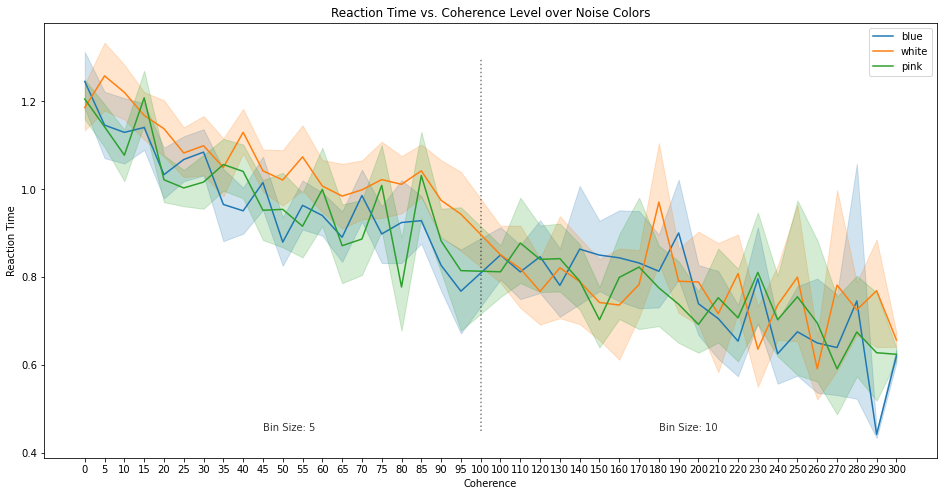

In [9]:
binsizes = [5,10]
bin_borders = [100,300]
bins = list(range(0,bin_borders[0]+1,binsizes[0])) + list(range(bin_borders[0], bin_borders[1]+1, binsizes[1]))
# Set up plot
fig, ax = plt.subplots(figsize=(16,8))
ax.set_xticks(list(range(1,len(bins)+1)))
ax.set_xticklabels([str(i) for i in bins]);

for color in ['blue','white','pink']:
    df = data[(data['Noise Color'] == color) & (data['Correct Response']==1)]
    bined_df = df.copy()
    bined_df['Coherence'] = np.digitize(df['Coherence'], bins)
    sns.lineplot(data=bined_df, x='Coherence', y='Reaction Time', ax=ax, label=color)

ax.vlines(105/5, 0.45, 1.3, 'k', 'dotted', alpha=0.5)
ax.text(x=10, y = 0.45, s='Bin Size: 5', alpha=0.8)
ax.text(x=30, y = 0.45, s='Bin Size: 10', alpha=0.8)
ax.set_title('Reaction Time vs. Coherence Level over Noise Colors')